# Data

## Dataset

In [1]:
import os
import json
import torch
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import savgol, minmax_scaler, get_logger

torch.manual_seed(0)

label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

class Sensor2AngleDataset(Dataset):
    def __init__(self, dataDir, windowLength): 
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample, angleSample = self.data[index]
        return sensorSample, angleSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir) / "sensor.npy"
        anglePath = Path(dataDir) / "angle.npy"
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        with open(anglePath, 'rb') as f:
            angleAll = np.load(f)
        assert sensorAll.shape[0] == angleAll.shape[0]
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll, angleAll = self.filter_sensor_and_angle(sensorAll, angleAll)
        sensorWindowsAll, angleWindowsAll = self.sliding_window(sensorAll, angleAll, windowLength)
        datasetList = []
        for sensorSample, angleSample in zip(sensorWindowsAll, angleWindowsAll):
            datasetList.append([sensorSample, angleSample]) 
        return datasetList
    
    def standardize_sensor(self, sensorAll):
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        # time-wise standardize
#         scalerStd = StandardScaler()
#         sensorStd = scalerStd.fit_transform(sensorAll)
        return sensorAllStd

    def filter_sensor_and_angle(self, sensorAll, angleAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        angleFlt = []
        for i in range(angleAll.shape[1]):
            title = label_names[i]
            angleAll[:,i] = savgol(angleAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll, angleAll
    
    def sliding_window(self, sensorAll, angleAll, windowLength):
        senserAllWindows = []
        angleAllWindows = []
        assert(sensorAll.shape[0] == angleAll.shape[0])
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            _y = angleAll[i+windowLength-1]
            senserAllWindows.append(_x)
            angleAllWindows.append(_y) 
        return senserAllWindows, angleAllWindows
    
    
class Sensor2AngleTestDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample = self.data[index]
        return sensorSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir)
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll = self.filter_sensor(sensorAll)
        sensorWindowsAll = self.sliding_window(sensorAll, windowLength)
        return sensorWindowsAll
    
    def standardize_sensor(self, sensorAll):
        # TODO
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        return sensorAllStd

    def filter_sensor(self, sensorAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll
    
    def sliding_window(self, sensorAll, windowLength):
        senserAllWindows = []
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            senserAllWindows.append(_x)
        return senserAllWindows

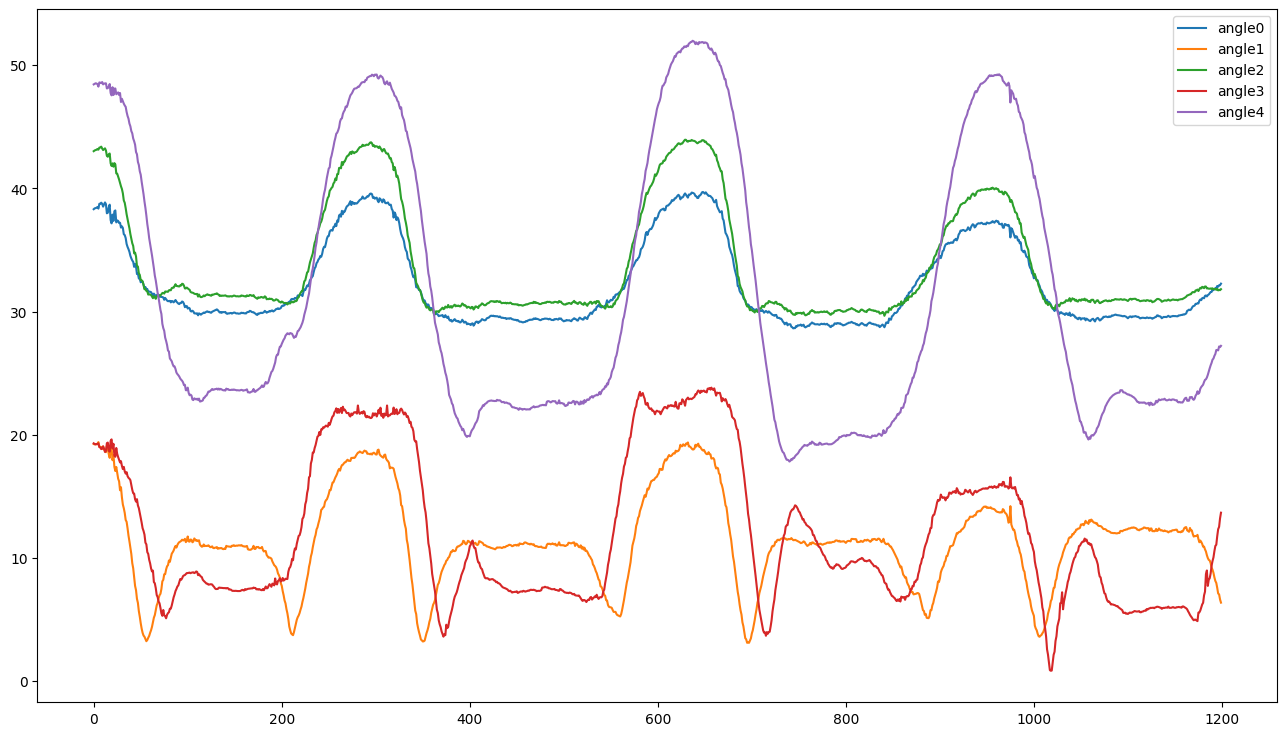

In [2]:
dataDir='./data/trainset/'

anglePath = Path(dataDir) / "angle.npy"
with open(anglePath, 'rb') as f:
    angleAll = np.load(f)
figure(figsize=(16, 9), dpi=100)
for i in range(5):
    plt.plot(angleAll[:1200,i], label=f'angle{i}')
plt.legend()
plt.show()

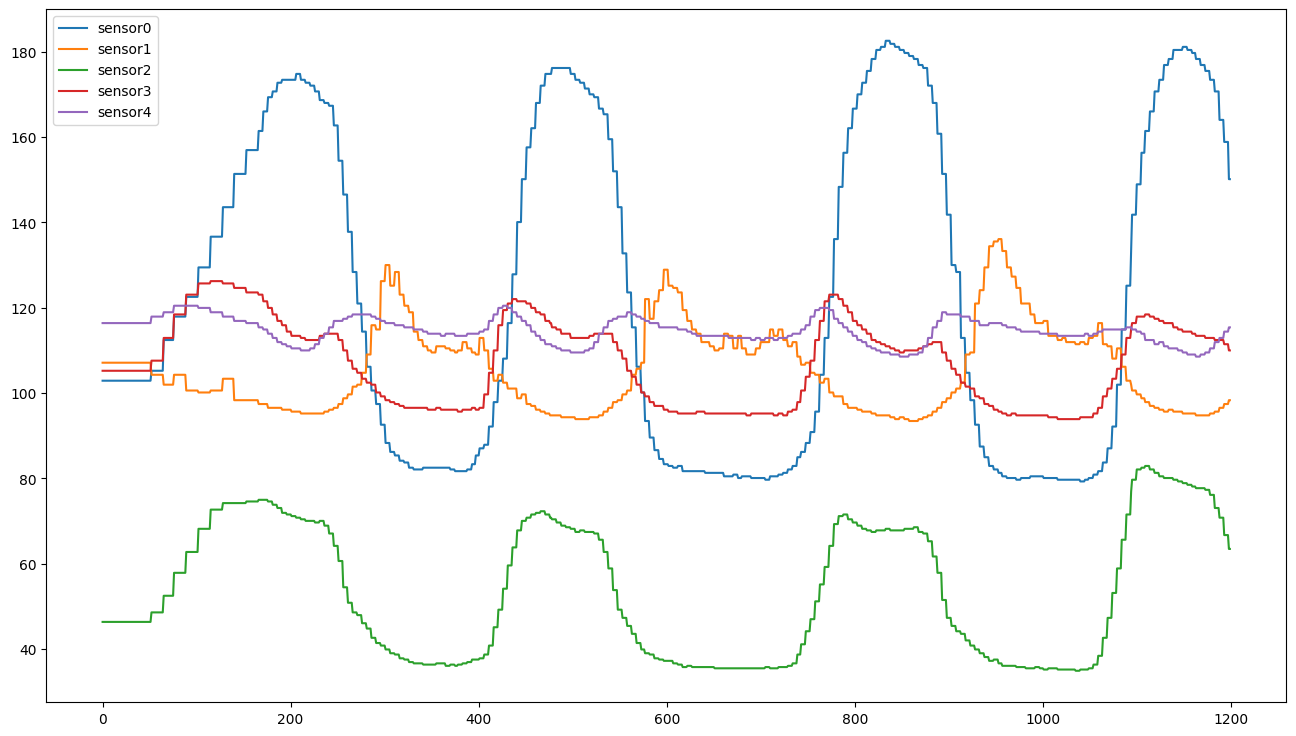

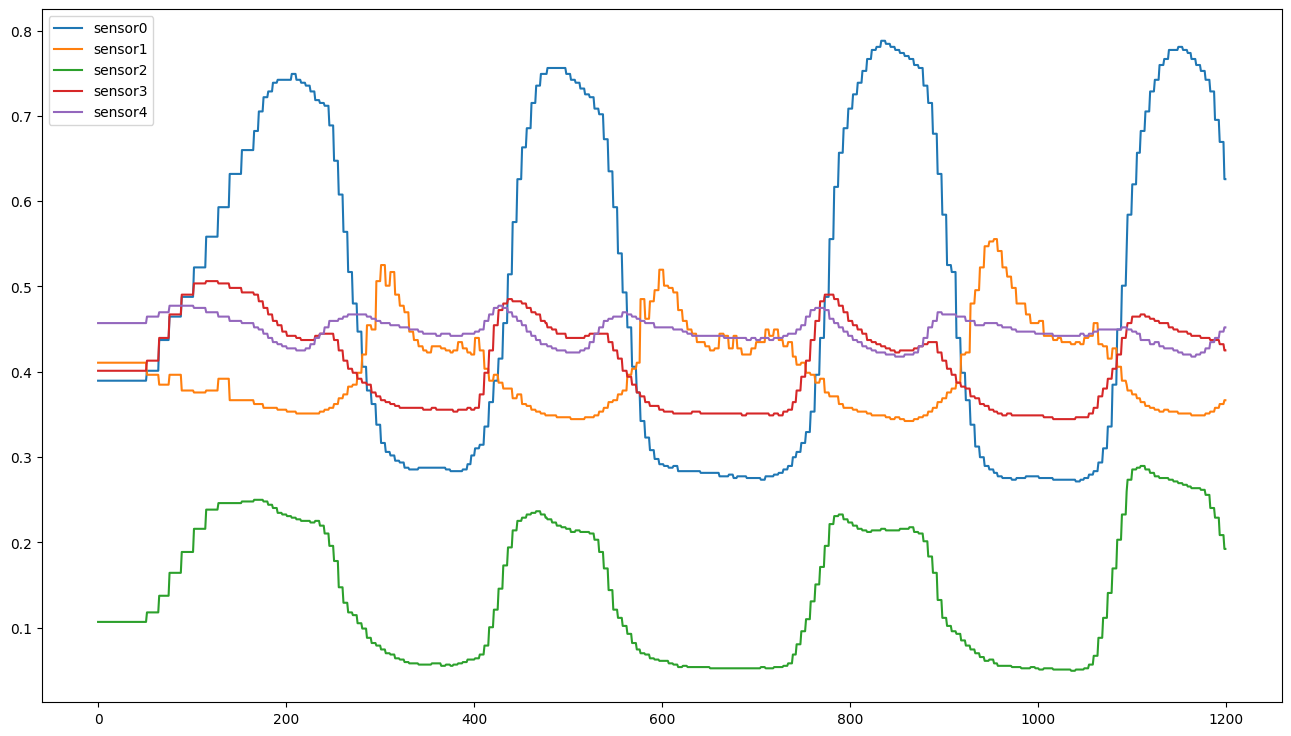

In [3]:
def compare_standarize_methods(dataDir='./data/trainset/'):
    sensorPath = Path(dataDir) / "sensor.npy"
    with open(sensorPath, 'rb') as f:
        sensorAll = np.load(f)
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAll[:1200,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
    sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAllStd[:1200,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
compare_standarize_methods()

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    sensor, angle = zip(*batch)
    return torch.FloatTensor(sensor), torch.FloatTensor(angle)


def get_dataloader(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    trainset_dir = os.path.join(data_dir, 'trainset')
    testset_dir = os.path.join(data_dir, 'testset')
    
    trainset = Sensor2AngleDataset(trainset_dir, windowLength)
    testset = Sensor2AngleDataset(testset_dir, windowLength)
    
    # Split dataset into training dataset and validation dataset
    # dataset = Sensor2AngleDataset(trainset_dir, windowLength)
    # trainlen = int(0.8 * len(dataset))
    # validlen = int(0.1 * len(dataset))
    # testlen = len(dataset) - trainlen - validlen
    # lengths = [trainlen, validlen, testlen]
    # trainset, validset, testset = random_split(dataset, lengths)
    
    trainlen = int(0.9 * len(trainset))
    validlen = len(trainset) - trainlen
    testlen = len(testset)
    lengths = [trainlen, validlen]
    trainset, validset = random_split(trainset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    num_workers=n_workers,
    shuffle=False,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    
    return train_loader, valid_loader, test_loader


def get_dataloader_vis(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    visset_dir = os.path.join(data_dir, 'visset')
    visset = Sensor2AngleDataset(visset_dir, windowLength)
    
    vis_loader = DataLoader(
    visset,
    batch_size=batch_size,
    num_workers=n_workers,
    shuffle=False,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    
    return vis_loader

In [5]:
train_loader, valid_loader, test_loader = get_dataloader('./data/', 32, 64, 0)
vis_loader = get_dataloader('./data/', 32, 64, 0)
print(f'Length of trainset: {len(train_loader) * 64}')
print(f'Length of validset: {len(valid_loader)* 64}')
print(f'Length of testset: {len(test_loader) * 64}')
print(f'Length of visset: {len(vis_loader) * 64}')

(62259, 5)
(9697, 5)
(62259, 5)
(9697, 5)
Length of trainset: 56000
Length of validset: 6208
Length of testset: 9664
Length of visset: 192


In [6]:
from matplotlib import pyplot as plt

train_iterator = iter(train_loader)
batch = next(train_iterator)


x = batch[0].numpy()[0]
y = batch[1].numpy()[0]

print(y)

/tmp/ipykernel_331428/3134429178.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(sensor), torch.FloatTensor(angle)


[32.471878  9.484957 33.400112 10.277271 24.674728 22.802418]


# Model
- LSTM
- Attention
- ChannleWise-TemporalWise-Attention
- Attention + LSTM
- LSTM + Attention

In [7]:
##### import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, 
                 d_channel, 
                 d_temporal, 
                 d_lstm_hidden, 
                 lstm_num_layers,
                 window_length, 
                 dropout):
        super().__init__()
        self.encoderLayer = nn.Sequential(
            nn.Linear(5, d_channel),
            nn.ReLU(),
            nn.Linear(d_channel, d_channel*2),
            nn.ReLU(),
            nn.Linear(d_channel*2, d_channel),
        )
        self.lstm = nn.LSTM(input_size=d_channel, 
                            hidden_size=d_lstm_hidden,
                            num_layers=lstm_num_layers)
        self.predLayer = nn.Sequential(
          nn.Linear(d_lstm_hidden, d_lstm_hidden),
          nn.ReLU(),
          nn.Linear(d_lstm_hidden, 6))

    def forward(self, sensors):
        """
        About Pytorch LSTM:
        https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        out = self.encoderLayer(sensors)          # (batch size, length, d_channel)
        out, (hn, cn) = self.lstm(out)              # (length, batch size, d_lstm_hidden)
        out = out[-1,:,:]                           # (batch size, d_lstm_hidden)    
        out = self.predLayer(out)                   # (batch size, num_angles)

        return out


from torchinfo import summary
print(summary(LSTM(
                 d_channel=128, 
                 d_temporal=32, 
                 d_lstm_hidden=64, 
                 lstm_num_layers=2,
                 window_length=32, 
                 dropout=0.1), 
                 input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [32, 6]                   --
├─Sequential: 1-1                        [8, 32, 128]              --
│    └─Linear: 2-1                       [8, 32, 128]              768
│    └─ReLU: 2-2                         [8, 32, 128]              --
│    └─Linear: 2-3                       [8, 32, 256]              33,024
│    └─ReLU: 2-4                         [8, 32, 256]              --
│    └─Linear: 2-5                       [8, 32, 128]              32,896
├─LSTM: 1-2                              [8, 32, 64]               82,944
├─Sequential: 1-3                        [32, 6]                   --
│    └─Linear: 2-6                       [32, 64]                  4,160
│    └─ReLU: 2-7                         [32, 64]                  --
│    └─Linear: 2-8                       [32, 6]                   390
Total params: 154,182
Trainable params: 154,182
Non-trainable params

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, d_channel, d_temporal, window_length, dropout):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.channelEncoder = nn.Linear(5, d_channel)
        self.temporalEncoder = nn.Linear(window_length, d_temporal)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
        # self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
        #   d_model=window_length, dim_feedforward=1024, nhead=8, dropout=dropout
        # )
        self.temporalwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=d_temporal, dim_feedforward=1024, nhead=8, dropout=dropout
        )
        self.predLayer = nn.Sequential(
          nn.Linear(d_temporal, d_temporal),
          nn.ReLU(),
          nn.Linear(d_temporal, 6),
        )

    def forward(self, sensors):
        """
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        # out: (batch size, length, d_channel)
        out = self.channelEncoder(sensors)
        # The encoder layer expect features in the shape of (args, batch size, args).
        # out: (d_channel, batch size, length)
        # out = out.permute(2, 0, 1)
        # out: (d_channel, batch size, length)
        # out = self.channelwiseAttentionLayer(out)
        # out: (batch size, d_channel, length)
        out = out.permute(0, 2, 1)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalEncoder(out)
        # # out: (batch size, d_channel, d_temporal)
        out = self.temporalwiseAttentionLayer(out)
        # # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.predLayer(stats)
        return out


from torchinfo import summary
print(summary(Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
Attention                                [8, 6]                    --
├─Linear: 1-1                            [8, 32, 128]              768
├─Linear: 1-2                            [8, 128, 32]              1,056
├─TransformerEncoderLayer: 1-3           [8, 128, 32]              --
│    └─MultiheadAttention: 2-1           [8, 128, 32]              4,224
│    └─Dropout: 2-2                      [8, 128, 32]              --
│    └─LayerNorm: 2-3                    [8, 128, 32]              64
│    └─Linear: 2-4                       [8, 128, 1024]            33,792
│    └─Dropout: 2-5                      [8, 128, 1024]            --
│    └─Linear: 2-6                       [8, 128, 32]              32,800
│    └─Dropout: 2-7                      [8, 128, 32]              --
│    └─LayerNorm: 2-8                    [8, 128, 32]              64
├─Sequential: 1-4                        [8, 6]                    --


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CTAttention(nn.Module):
    def __init__(self, d_channel, d_temporal, window_length, dropout):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.channelEncoder = nn.Linear(5, d_channel)
        self.temporalEncoder = nn.Linear(window_length, d_temporal)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=1024, nhead=8, dropout=dropout
        )
        self.temporalwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=d_temporal, dim_feedforward=1024, nhead=8, dropout=dropout
        )
        self.predLayer = nn.Sequential(
          nn.Linear(d_temporal, d_temporal),
          nn.ReLU(),
          nn.Linear(d_temporal, 6),
        )

    def forward(self, sensors):
        """
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        # out: (batch size, length, d_channel)
        out = self.channelEncoder(sensors)
        # The encoder layer expect features in the shape of (args, batch size, args).
        # out: (d_channel, batch size, length)
        out = out.permute(2, 0, 1)
        # out: (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)
        # out: (batch size, d_channel, length)
        out = out.permute(1, 0, 2)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalEncoder(out)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalwiseAttentionLayer(out)
        # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.predLayer(stats)
        return out


from torchinfo import summary
print(summary(CTAttention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
CTAttention                              [8, 6]                    --
├─Linear: 1-1                            [8, 32, 128]              768
├─TransformerEncoderLayer: 1-2           [128, 8, 32]              --
│    └─MultiheadAttention: 2-1           [128, 8, 32]              4,224
│    └─Dropout: 2-2                      [128, 8, 32]              --
│    └─LayerNorm: 2-3                    [128, 8, 32]              64
│    └─Linear: 2-4                       [128, 8, 1024]            33,792
│    └─Dropout: 2-5                      [128, 8, 1024]            --
│    └─Linear: 2-6                       [128, 8, 32]              32,800
│    └─Dropout: 2-7                      [128, 8, 32]              --
│    └─LayerNorm: 2-8                    [128, 8, 32]              64
├─Linear: 1-3                            [8, 128, 32]              1,056
├─TransformerEncoderLayer: 1-4           [8, 128, 32]              --


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, 
                 d_channel, 
                 d_temporal, 
                 d_lstm_hidden, 
                 lstm_num_layers,
                 window_length, 
                 dropout):
        super().__init__()
        self.channelEncoder = nn.Linear(5, d_channel)
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=1024, nhead=8, dropout=dropout)
        self.lstm = nn.LSTM(input_size=d_channel, 
                            hidden_size=d_lstm_hidden,
                            num_layers=lstm_num_layers)
        self.predLayer = nn.Sequential(
          nn.Linear(d_lstm_hidden, d_lstm_hidden),
          nn.ReLU(),
          nn.Linear(d_lstm_hidden, 6))

    def forward(self, sensors):
        """
        About Pytorch LSTM:
        https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        out = self.channelEncoder(sensors)          # (batch size, length, d_channel)
        out = out.permute(2, 0, 1)                  # (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)   # (d_channel, batch size, length)
        out = out.permute(2, 1, 0)                  # (length， batch size, d_channel)
        out, (hn, cn) = self.lstm(out)              # (length, batch size, d_lstm_hidden)
        out = out[-1,:,:]                           # (batch size, d_lstm_hidden)    
        out = self.predLayer(out)                   # (batch size, num_angles)
        
        return out


from torchinfo import summary
print(summary(AttentionLSTM(
                 d_channel=128, 
                 d_temporal=32, 
                 d_lstm_hidden=64, 
                 lstm_num_layers=2,
                 window_length=32, 
                 dropout=0.1), 
                 input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionLSTM                            [8, 6]                    --
├─Linear: 1-1                            [8, 32, 128]              768
├─TransformerEncoderLayer: 1-2           [128, 8, 32]              --
│    └─MultiheadAttention: 2-1           [128, 8, 32]              4,224
│    └─Dropout: 2-2                      [128, 8, 32]              --
│    └─LayerNorm: 2-3                    [128, 8, 32]              64
│    └─Linear: 2-4                       [128, 8, 1024]            33,792
│    └─Dropout: 2-5                      [128, 8, 1024]            --
│    └─Linear: 2-6                       [128, 8, 32]              32,800
│    └─Dropout: 2-7                      [128, 8, 32]              --
│    └─LayerNorm: 2-8                    [128, 8, 32]              64
├─LSTM: 1-3                              [32, 8, 64]               82,944
├─Sequential: 1-4                        [8, 6]                    --

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [11]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule twhe learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

    Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
          max(1, num_training_steps - num_warmup_steps)
        )
        return max(
          0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [12]:
import torch


def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""
    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)
    outs = model(mels)
    loss = criterion(outs, labels)
    
    return loss

In [13]:
# train_loader, valid_loader = get_dataloader(data_dir='./data',
#                                             windowLength=120, 
#                                             batch_size=32, 
#                                             n_workers=0)
# train_iterator = iter(train_loader)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Attention().to(device)
# batch = next(train_iterator)
# mels, labels = batch
# mels = mels.to(device)
# labels = labels.to(device)

# outs = model(mels)

# Validate
- Calculate mse_loss of the validation set.

In [14]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""
    model.eval()
    running_loss = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss = model_fn(batch, model, criterion, device)
            running_loss += loss.item()


        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
        loss=f"{running_loss / (i+1):.2f}")

    pbar.close()
    model.train()

    return running_loss / len(dataloader)

# Train

In [ ]:
# from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

# Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(64, 32, 5))

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/",
    # "save_path": f"model/CTAttention-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.ckpt",
    "save_path": f"model/AttentionLSTM-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.ckpt",
    # "save_path": f"model/Attention-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.ckpt",
        
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32, # 32 / 64
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.5,
    "batch_size": 32,
    
    "n_workers": 0,
    "valid_steps": 5000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 200000,
    }

    return config


def main(
    data_dir,
    save_path,
    
    window_length,
    d_channel,
    d_temporal,
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size,
    
    n_workers,
    valid_steps,
    warmup_steps,
    save_steps,
    total_steps,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, _ = get_dataloader(data_dir, window_length, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    # model = CTAttention(d_channel, d_temporal, window_length, dropout).to(device)
    model = AttentionLSTM(d_channel, d_temporal, d_lstm_hidden, lstm_num_layers, window_length, dropout).to(device)
    # model = Attention(d_channel, d_temporal, window_length, dropout).to(device)
    
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_mse_loss = 10000.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        # Get data
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss = model_fn(batch, model, criterion, device)
        batch_loss = loss.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
          loss=f"{batch_loss:.2f}",
          step=step + 1,
        )

        # Do validation
        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_mse_loss = valid(valid_loader, model, criterion, device)
            # keep the best model
            if valid_mse_loss < best_mse_loss:
                best_mse_loss = valid_mse_loss
                best_state_dict = model.state_dict()
            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (mse_loss={best_mse_loss:.4f})")

    pbar.close()


if __name__ == "__main__":
    main(**parse_args())

[Info]: Use cuda now!
(62259, 5)
(9697, 5)
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 5000/5000 [00:35<00:00, 140.20 step/s, loss=88.19, step=5000] 
Valid: 100% 6208/6223 [00:00<00:00, 9657.77 uttr/s, loss=103.08] 
Train: 100% 5000/5000 [01:19<00:00, 63.16 step/s, loss=8.35, step=6e+4]  
Valid: 100% 6208/6223 [00:01<00:00, 4984.09 uttr/s, loss=14.69]
Train:   0% 14/5000 [00:00<01:19, 62.79 step/s, loss=8.58, step=6e+4] 

Step 60000, best model saved. (mse_loss=14.6936)


Train: 100% 5000/5000 [01:20<00:00, 61.90 step/s, loss=12.54, step=85000] 
Valid: 100% 6208/6223 [00:01<00:00, 4838.87 uttr/s, loss=9.49] 
Train:   8% 382/5000 [00:06<01:11, 64.68 step/s, loss=17.87, step=85382]

# Evaluation

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/",
    "model_path": "./model/AttentionLSTM-2023-05-18-13-56.ckpt",
    "output_path": "./result/output.csv",          
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32, # 32 / 64
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.0,
    "batch_size": 1,
    "n_workers": 0
    }

    return config


def evaluation(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_channel,
    d_temporal, 
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size,
    n_workers
):

    """Main function."""
    _, tempfilename = os.path.split(model_path)
    (modelName, extension) = os.path.splitext(tempfilename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    # _, _, test_loader = get_dataloader(data_dir, window_length, batch_size, n_workers)
    test_loader = get_dataloader_vis(data_dir, window_length, batch_size, n_workers)
    # dataset = Sensor2AngleDataset(data_dir, window_length)
    # model = CTAttention(d_channel, d_temporal, window_length, dropout)
    model = AttentionLSTM(d_channel, d_temporal, d_lstm_hidden, lstm_num_layers, window_length, dropout)
    # model = Attention(d_channel, d_temporal, window_length, dropout)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    criterion = nn.MSELoss()
    loss_list = []
    results = [["Label", "Preds"]]
    angles_list = []
    preds_list = []
    for sensor, angle in tqdm(test_loader):
        with torch.no_grad():
#             sensor = sensor.to(device)
            sensor = sensor
            outs = model(sensor)
            preds = outs.cpu()
            results.append([angle.numpy(), preds.numpy()])
            angles_list.append(angle.numpy())
            preds_list.append(preds.numpy())
            
            loss = criterion(preds, angle)
            loss_list.append(loss.item())

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results)
        print(f"[Info]: Finish save results!",flush = True)
        
    preds_list = np.array(preds_list).squeeze()
    angles_list = np.array(angles_list).squeeze()
    r2_avg = r2_score(angles_list, preds_list, multioutput='uniform_average')
    r2_var = r2_score(angles_list, preds_list, multioutput='variance_weighted')
    
    # logging
    logger = get_logger('info', log_file=f'./log/{modelName}.log')
    logger.info(f'RMSE loss on testset:, {np.sqrt(np.array(loss_list).mean())}')
    logger.info(f'R2_avg loss on testset:, {r2_avg}')
    logger.info(f'R2_var loss on testset:, {r2_var}')
    
    return preds_list, angles_list
    
if __name__ == "__main__":
    preds_list, angles_list = evaluation(**parse_args())

In [ ]:
def visualize_result(label, predict, modelName):
    start = 0
    end = 4200
    for i in range(6):
        figure(figsize=(70, 7), dpi=100)
        
        plt.plot(label[start:end,i], color='g', label='ground truth')
        plt.plot(predict[start:end,i], color='gray', label='prediction')
        plt.title(label_names[i])
        axes = plt.gca()
        min_y = int(min(predict[start:end,i]))
        max_y = int(max(predict[start:end,i]))
                    
        # axes.set_ylim([min_y, max_y])
        axes.set_ylim([0, 90])
        plt.legend()
        # plt.savefig(f'result/test/trainDataset_{label_names[i]}.png')
    plt.show()

modelName = 'AttentionLSTM'
visualize_result(angles_list[:], preds_list[:], modelName)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x1 = np.linspace(0,2*np.pi,400)
y1 = np.cos(x1**2)

x2 = np.linspace(0.01,10,100)
y2 = np.sin(x2)

x3 = np.random.randn(100)
y3 = np.linspace(0,3,100)

x4 = np.arange(0,6,0.5)
y4 = np.power(x4,3)

fig,ax = plt.subplots(4,1,sharex = "all")

fig.subplots_adjust(hspace = 0)

ax1 = ax[0]
ax1.plot(x1,y1)

ax2 = ax[1]
ax2.plot(x2,y2)

ax3 = ax[2]
ax3.scatter(x3,y3)

ax4 = ax[3]
ax4.scatter(x4,y4)

plt.show()

# Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/testset/slow.npy",
    "model_path": "./model/attentionLSTM-2021-09-09-15-03.ckpt",
    "output_path": "./result/output.csv",
        
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.0,
    "batch_size": 1
    }

    return config


def inference(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_channel, 
    d_temporal,
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size
):
    """Main function."""
    _, tempfilename = os.path.split(model_path)
    (modelName, extension) = os.path.splitext(tempfilename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleTestDataset(data_dir, window_length)
    dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    )
    
    print(f"[Info]: Finish loading data!",flush = True)
    
#     model = Attention(d_model, dropout).to(device)
    model = AttentionLSTM(d_channel,
                          d_temporal,
                          d_lstm_hidden,
                          lstm_num_layers,
                          window_length,
                          dropout)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    preds_list = []
    for sensor in tqdm(dataloader):
        with torch.no_grad():
            sensor = sensor.float()
            outs = model(sensor)
            preds = outs.cpu()
            preds_list.append(preds.numpy())
    # visualization
    preds_list = np.array(preds_list).squeeze()
    sensor_list = np.load(data_dir)
    visualize_result(sensor_list, preds_list, folderPath=logpath, dataDir=data_dir)

    
def visualize_result(sensor, predict, folderPath, dataDir):
    figure(figsize=(12, 7), dpi=100)
    axes = plt.gca()
    axes.set_ylim([0,180])
    for i in range(6):
        plt.plot(predict[:,i], label=label_names[i])
        plt.legend()
    for j in range(5):
        plt.plot(sensor[:,j], color='b', label=label_names[j])
    plt.title(dataDir)
    os.mkdir(os.path.join('./result/fading/', os.path.basename(folderPath)))
    savefigPath = os.path.join(f'./result/fading/',
                                os.path.basename(modelName),
                                os.path.basename(dataDir).replace('.npy', '.png'))
    plt.savefig(savefigPath)
    plt.show()

if __name__ == "__main__":
    inference(**parse_args())